# Getting Started
Welcome to pyROX! These notebooks (also available on [GitHub](https://github.com/samderegt/pyROX/tree/main/docs/notebooks)) will explain how to use pyROX and some of its features. 

After [installation](../index.html), pyROX can be called directly from a terminal using the `pyROX` command. The first positional argument should be a python-script with configuration parameters. This notebook outlines examples of these parameters and we'll use them to calculate opacity cross-sections of AlH.

In [1]:
from pyROX import utils, cross_sections

## Configuration parameters
We'll use the [AloHa line list](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.9736Y/abstract) calculated by the ExoMol team as the input data for pyROX. The configuration file [`examples/exomol_alh/exomol_alh.py`](https://github.com/samderegt/pyROX/blob/main/examples/exomol_alh/exomol_alh.py) begins with some basic information on the database and species.

In [2]:
# Basic information on database and species
database = 'exomol' # Can be ['exomol', 'hitran', 'hitemp', 'kurucz]
species  = 'alh'    # Species name
mass = 27.98948     # Can be found in *.def.json file

<div class="alert alert-warning">
    <strong>Units in pyROX:</strong> Internally, pyROX uses SI units and the output products are thus also in units of m, m<sup>2</sup>(/molecule), Pa, and K for wavelength, cross-sections, pressure and temperature, respectively. However, since line lists are not in SI we have chosen to allow more generally adopted units for the input parameters (e.g. amu, µm, cm<sup>-1</sup>). <strong>Warnings are raised to show the expected unit of the given parameters.</strong>
</div>

Next, we define the directories where the input-data and output-data should be stored. In addition, we provide a URL to download the definition-file (`*.def.json`) from the ExoMol website. This file is read in and the partition-function, transitions and state-energies will be downloaded and stored in the `input_data_dir` directory. In addition, we'll download pressure-broadening coefficients for perturbations by H<sub>2</sub> and He.

<div class="alert alert-info">
    <strong>Note:</strong> The download instructions are different for the other databases. See the [\"Database differences\"](database_differences.ipynb) for more information.
</div>

In [3]:
# Input/output-directories
input_data_dir  = './examples/exomol_alh/input_data/'
output_data_dir = './examples/exomol_alh/'

# Instructions to download from ExoMol database
urls = [
    'https://www.exomol.com/db/AlH/27Al-1H/AloHa/27Al-1H__AloHa.def.json', 
    'https://www.exomol.com/db/AlH/27Al-1H/27Al-1H__H2.broad', 
    'https://www.exomol.com/db/AlH/27Al-1H/27Al-1H__He.broad', 
]

The downloaded files are `27Al-1H__AloHa.trans.bz2`, `27Al-1H__AloHa.states.bz2`, and `27Al-1H__AloHa.pf` which are given as the `transitions`, `states`, and `partition_function` keys. 

In [4]:
# Input-data files
files = dict(
    transitions = f'{input_data_dir}/27Al-1H__AloHa.trans.bz2',
    states      = f'{input_data_dir}/27Al-1H__AloHa.states.bz2',
    partition_function = f'{input_data_dir}/27Al-1H__AloHa.pf',
)

### Pressure-temperature and wavenumber grids

Next, we define the pressure-temperature grid on which to calculate the opacities ($8\times2=16$ PT-points in this example). 

In addition, we'll set up the wavenumber grid ranging from wavelengths $\lambda=0.3$ to $28\ \mathrm{\mu m}$ with an equal spacing in wavenumber $\Delta\nu=0.01\ \mathrm{cm^{-1}}$. 

<div class="alert alert-info">
    <strong>Note:</strong> The wavenumber/wavelength grid can be defined in several ways:
    <ul>
        <li>Reading in custom wavelengths (in µm) from a file (e.g. `wave_file='wave_um.dat'`).</li>
    </ul>
    <ul>
        <li>Defining the range explicitly using `wave_min=0.3`, `wave_max=28.0` (in µm) or `nu_min`, `nu_max` (in cm<sup>-1</sup>).</li>
        <li>Using an equal wavenumber- or wavelength-spacing (e.g. `delta_nu=0.01` in cm<sup>-1</sup> or `delta_wave=1e-3` in µm).</li>
        <li>Using a fixed resolution (e.g. `resolution=1e6`).</li>
    </ul>
</div>

The `adaptive_nu_grid` flag will make the wavenumber grid coarser if the lines are substantially broadened (i.e. at high pressures), which speeds up the line-profile calculations. The `adaptive_nu_grid` flag only works for equal wavenumber-spacings.

In [5]:
import numpy as np
# Pressure and temperature grids
P_grid = np.logspace(-3, 2, 6) # [bar]
T_grid = np.array([1000,2000]) # [K]

# Wavenumber grid
wave_min = 0.3; wave_max = 28.0 # [um]
delta_nu = 0.01 # [cm^-1]
adaptive_nu_grid = True # Switch to sparser wavenumber grid for high broadening?

### Broadening information

pyROX considers three sources of broadening: Doppler, natural, and pressure (or Van der Waals) broadening. Doppler broadening is caused by the aborber's thermal motion and is thus controlled by the transition energy and temperature ($\gamma_\mathrm{D} \propto \nu_0\sqrt{T}$). Natural broadening arises from the uncertainty principle and can be described with the Einstein $A_{ul}$ coefficient of each transition $\gamma_\mathrm{N}\propto A_{ul}$. The Doppler and natural broadening widths are automatically calculated by pyROX.

Pressure broadening results from perturbations by other atoms/molecules and can be described in a multitude of ways, depending on the absorber, perturber, quantum states etc. In this case, we assume an atmosphere dominated by H<sub>2</sub> and He and provide information in the `perturber_info` dictionary. For each perturber, we specify its volume-mixing ratio (`VMR`) and refer to a `file` which contains the broadening coefficients $\gamma$ and $n$. The pressure-broadening coefficient is then calculated as the sum over all perturbers
$$
\gamma_\mathrm{vdW} = \sum_i \gamma_i \cdot \left(\frac{T_\mathrm{ref}}{T}\right)^{n_i} \cdot \left(\frac{P}{1\ \mathrm{atm}}\right)\cdot \mathrm{VMR}_i, 
$$
where $T_\mathrm{ref}=296\ \mathrm{K}$ is a reference temperature. 

<div class="alert alert-info">
    <strong>Note:</strong> The pressure broadening description has various options which are outlined in [\"Pressure Broadening\"](pressure_broadening.ipynb).
</div>

In [6]:
# Pressure-broadening information
perturber_info = dict(
    H2 = dict(VMR=0.85, file=f'{input_data_dir}/27Al-1H__H2.broad'), # Read from file
    He = dict(VMR=0.15, file=f'{input_data_dir}/27Al-1H__He.broad'),
)

### Line-strength and wing cutoffs

The convolution of a Gaussian profile (Doppler) and a Lorentzian profile (natural+pressure) results in a Voigt profile, which is generally slow to compute as no analytical function exists. Since line lists can consist of millions/billions of transitions, it can be beneficial to ignore lines with minor contributions to the total opacity. 

The `global_cutoff` parameter removes any transitions with line-strengths, $S(T)$, below the given threshold. The `local_cutoff` is given as a fraction of the cumulative line-strength within a wavenumber grid-point, $S_\mathrm{tot}(T,\nu_i)$. Any transitions with line-strengths below `local_cutoff`$\cdot S_\mathrm{tot}(T,\nu_i)$ are removed and their strengths get added to the strongest line in that bin. No cutoffs are applied if the respective parameter is not given. 

The `wing_cutoff` controls the extent to which the line profile is computed. Since different prescriptions exist in the literature, pyROX allows the `wing_cutoff` to be a function which takes the Voigt-width (in $\mathrm{cm^{-1}}$) and pressure (in bar) as input arguments. The function should output the cutoff distance from the line centre in $\mathrm{cm^{-1}}$. The default function (used here) follows [Gharib-Nezhad et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024RASTI...3...44G/abstract).

In [7]:
# Line-strength cutoffs
global_cutoff = 1e-45 # [cm^-1 / (molecule cm^-2)]
local_cutoff  = 0.25

# Function with arguments gamma_V [cm^-1], and P [bar]
wing_cutoff = lambda gamma_V, P: 25 if P<=200 else 100 # Gharib-Nezhad et al. (2024)

## Downloading from the database

We now have all the parameters to calculate the AlH cross-sections! If pyROX is called from the command line, it requires the first positional argument to be a python-script with the above parameters. For instance, 
```bash
pyROX examples/exomol_alh/exomol_alh.py
```
will set up a `config` object which is used to initialise the code. In this notebook, we'll set up the `config` object manually with the following code-block.

In [8]:
# Setup a configuration object (done automatically when running pyROX from the command line)
config = utils.update_config_with_args(    
    database=database, species=species, mass=mass,
    input_data_dir=input_data_dir, output_data_dir=output_data_dir, urls=urls, files=files,
    P_grid=P_grid, T_grid=T_grid, wave_min=wave_min, wave_max=wave_max, 
    delta_nu=delta_nu, adaptive_nu_grid=adaptive_nu_grid,

    perturber_info=perturber_info,
    local_cutoff=local_cutoff, global_cutoff=global_cutoff, wing_cutoff=wing_cutoff,
)


Updating configuration with new parameters
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "database" as "exomol".
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "species" as "alh".
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "mass" as 27.98948.
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "input_data_dir" as "./examples/exomol_alh/input_data/".
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "output_data_dir" as "./examples/exomol_alh/".
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "urls" as ['https://www.exomol.com/db/AlH/27Al-1H/AloHa/27Al-1H__AloHa.def.json', 'https://www.exomol.com/db/AlH/27Al-1H/27Al-1H__H2.broad', 'https://www.exomol.com/db/AlH/27Al-1H/27Al-1H__He.broad'].
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "files" as {'transitions': './examples/exomol_alh/input_data//

We'll now initialise the `data` object and download the line-list data from the ExoMol database. This is equivalent to the command
```bash
pyROX examples/exomol_alh/exomol_alh.py --download
```

In [9]:
# Download from the ExoMol database
data = cross_sections.load_data_object(config, download=True)

------------------------------------------------------------
  Line-by-line Absorption from ExoMol
------------------------------------------------------------


100% [............................................................] 5090 / 5090
100% [..............................................................] 960 / 960
100% [..............................................................] 959 / 959
100% [........................................................] 125000 / 125000
100% [..........................................................] 29546 / 29546
100% [........................................................] 156544 / 156544

Reading parameters from the configuration file
/net/lem/data2/regt/pyROX/pyROX/utils.py:245 UserWarning: Please make sure that the following parameters are given in the expected units:
  - P_grid [bar]
  - T_grid [K]
  - delta_nu [cm^-1]
  - global_cutoff [cm^-1 / (molecule cm^-2)]
  - mass [amu]
  - wave_max [um]
  - wave_min [um]
  - wing_cutoff [cm^-1]

## Calculating cross-sections

The line-list data should be found in the `input_data_dir` directory and we can calculate the opacity cross-sections from them. The following code-block is equivalent to running the command
```bash
pyROX examples/exomol_alh/exomol_alh.py --calculate
```

In [10]:
data.calculate_temporary_outputs(
    progress_bar=True, # Show progress bar
    #overwrite=False, # If True, answer "yes" to all overwrite prompts
)


Calculating cross-sections
  Reading states from "examples/exomol_alh/input_data/27Al-1H__AloHa.states.bz2"
  Reading transitions from "./examples/exomol_alh/input_data//27Al-1H__AloHa.trans.bz2"
  Number of lines loaded: 29725


  0%|                    | 0/12 [00:00<?, ?it/s]                                

100%|████████████████████| 12/12 [00:33<00:00,  2.78s/it, N_lines_computed=28514


  Saving temporary cross-sections to "/net/lem/data2/regt/pyROX/examples/exomol_alh/tmp/xsec_27Al-1H__AloHa.trans.hdf5"


This will save a temporary output-file in the `output_data_dir/tmp` directory. The reason for saving temporary files is to help parallelisation of the calculations (see [\"Parallelisation\"](../parallelisation.html)) and extensions of the pressure-temperature grid. 

### Adding more PT-points
Here, we'll extend the temperature grid with two more values, $T=500$ and $3000\ \mathrm{K}$. To avoid overwriting the previous output, we'll also change the base filename (`tmp_output_basename`) from `xsec.hdf5` (default) to `xsec_added_PT.hdf5`. The equivalent command is
```bash
pyROX examples/exomol_alh/exomol_alh.py --T_grid 500 3000 --tmp_output_basename xsec_added_PT.hdf5
```

<div class="alert alert-warning">
    <strong>Important:</strong> When extending the pressure-temperature grid, it is important that the final combined grid can be made rectangular. That is, every temperature should be calculated for every pressure. Setting `P_grid=1` (and `T_grid=[500,3000]`) would result in an error in this example.
</div>

In [11]:
# Update the configuration parameters
config = utils.update_config_with_args(
    config=config,     # Update the previous configuration
    T_grid=[500,3000], # Calculate for new temperatures [K]
    tmp_output_basename='xsec_added_PT.hdf5', # Make a new filename to avoid overwriting
)
# Re-load the data object
data = cross_sections.load_data_object(config, download=False)

# Calculate the cross-sections again
data.calculate_temporary_outputs(
    progress_bar=True, # Show progress bar
    #overwrite=False, # If True, answer "yes" to all overwrite prompts
)


Updating configuration with new parameters
/net/lem/data2/regt/pyROX/pyROX/utils.py:205 UserWarning: Overwriting parameter "T_grid" from [1000 2000] to [500, 3000].
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "tmp_output_basename" as "xsec_added_PT.hdf5".

------------------------------------------------------------
  Line-by-line Absorption from ExoMol
------------------------------------------------------------


Reading parameters from the configuration file
/net/lem/data2/regt/pyROX/pyROX/utils.py:245 UserWarning: Please make sure that the following parameters are given in the expected units:
  - P_grid [bar]
  - T_grid [K]
  - delta_nu [cm^-1]
  - global_cutoff [cm^-1 / (molecule cm^-2)]
  - mass [amu]
  - wave_max [um]
  - wave_min [um]
  - wing_cutoff [cm^-1]


Wavelength-grid:
  Wavelength: 0.30 - 28 um
  Wavenumber: 357 - 33333 cm^-1
  Fixed wavenumber-spacing: 0.010 cm^-1
  Number of grid points: 3297620
  Adaptive grid: True

Pressure broadeni

100%|████████████████████| 12/12 [00:30<00:00,  2.53s/it, N_lines_computed=28513


  Saving temporary cross-sections to "/net/lem/data2/regt/pyROX/examples/exomol_alh/tmp/xsec_added_PT_27Al-1H__AloHa.trans.hdf5"


## Merging temporary output-files and plotting

The two files in the `output_data_dir/tmp` directory can now be merged into a final, combined pressure-temperature grid. We'll also make a figure of the computed opacity cross-sections. The following code-block is equivalent to running the command
```bash
pyROX examples/exomol_alh/exomol_alh.py --save --plot
```


Combining temporary files and saving final output
  Merging 2 temporary files into a single grid
  Temporary files:
    - "xsec_27Al-1H__AloHa.trans.hdf5"
    - "xsec_added_PT_27Al-1H__AloHa.trans.hdf5"
  Saving final output to "/net/lem/data2/regt/pyROX/examples/exomol_alh/xsec.hdf5"

Plotting cross-sections


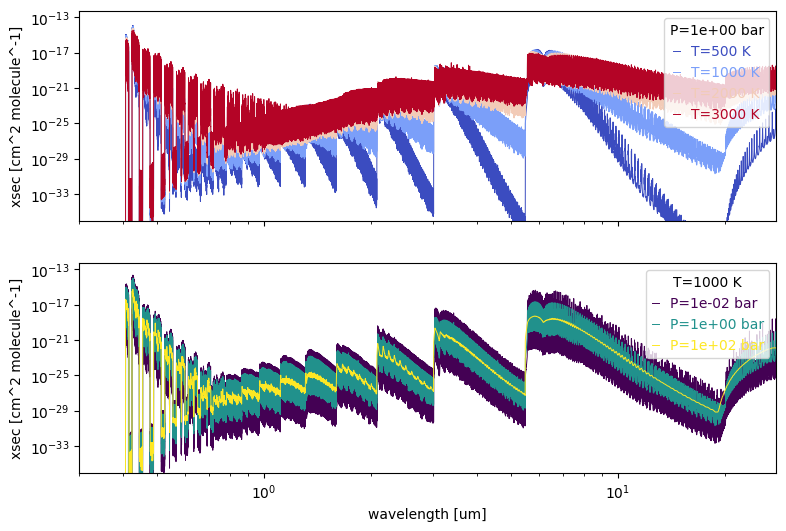

In [12]:
data.save_combined_outputs(
    #overwrite=False, # If True, answer "yes" to all overwrite prompts
)

fig, ax = data.plot_combined_outputs(
    T_to_plot=[500,1000,2000,3000], 
    P_to_plot=[1e-2, 1, 1e2], # [bar]
    return_fig_ax=True
)
fig.show()

<div class="alert alert-warning">
    <strong>Important:</strong> The final output-file is saved as a compressed `hdf5`-type. It has four datasets:
    <ul>
        <li>`P_grid`: Pressure grid points (in Pa).</li>
        <li>`T_grid`: Temperature grid points (in K).</li>
        <li>`wave`: Wavelength grid points (in m).</li>
        <li>`log10(xsec)`: Base-10 logarithm of the opacity cross-sections (in log10[m<sup>2</sup> molecule<sup>-1</sup>]) with shape (`wave`, `P_grid`, `T_grid`).</li>
    </ul>
</div>

## Converting to pRT3-format
pyROX offers built-in support for converting its standard output format into an `h5`-file that can be read in with [petitRADTRANS v3](https://petitradtrans.readthedocs.io/en/latest/content/adding_opacities.html). To generate the right filename and add metadata to the `h5`-file, we'll have to add the `pRT3_metadata` dictionary to the `config` object.

In [ ]:
# Metadata to be stored in pRT3's .h5 file
pRT3_metadata = dict(
    DOI = '10.1093/mnras/stad3802',      # DOI of the data
    mol_name = 'AlH',                    # Using the right capitalisation
    linelist = 'AloHa',                  # Line-list name, used in .h5 filename
    isotopologue_id = {'Al':27, 'H':1},  # Atomic number of each element
)

The following code-block will convert the opacities into the pRT3-format and is equivalent to the command
```bash
pyROX examples/exomol_alh/exomol_alh.py --convert_to_pRT3
```

In [14]:
# Update the configuration parameters
config = utils.update_config_with_args(
    config=config,     # Update the previous configuration
    pRT3_metadata=pRT3_metadata, # Add metadata
)
# Re-load the data object
data = cross_sections.load_data_object(config, download=False)

# Convert to the pRT3 format
data.convert_to_pRT3(contributor='Your name!')


Updating configuration with new parameters
/net/lem/data2/regt/pyROX/pyROX/utils.py:207 UserWarning: Adding parameter "pRT3_metadata" as {'DOI': '10.1093/mnras/stad3802', 'mol_name': 'AlH', 'linelist': 'AloHa', 'isotopologue_id': {'Al': 27, 'H': 1}}.

------------------------------------------------------------
  Line-by-line Absorption from ExoMol
------------------------------------------------------------


Reading parameters from the configuration file
/net/lem/data2/regt/pyROX/pyROX/utils.py:245 UserWarning: Please make sure that the following parameters are given in the expected units:
  - P_grid [bar]
  - T_grid [K]
  - delta_nu [cm^-1]
  - global_cutoff [cm^-1 / (molecule cm^-2)]
  - mass [amu]
  - wave_max [um]
  - wave_min [um]
  - wing_cutoff [cm^-1]


Wavelength-grid:
  Wavelength: 0.30 - 28 um
  Wavenumber: 357 - 33333 cm^-1
  Fixed wavenumber-spacing: 0.010 cm^-1
  Number of grid points: 3297620
  Adaptive grid: True

Pressure broadening info:
  - H2: VMR=0.85, mass=0.00

  Saved to "/net/lem/data2/regt/pyROX/examples/exomol_alh/27Al-1H__AloHa.R1e+06_0.3-28.0mu.xsec.petitRADTRANS.h5"
